# Import Libraries

In [1]:
import numpy as np
from numpy import pi
import cv2
import matplotlib.pyplot as plt
import open3d as o3d
import os
import torch

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Import Files

In [3]:
def ResizeWithAspectRatio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv2.resize(image, dim, interpolation=inter)

In [43]:
img = cv2.imread('data/Mountain_cropped.jpg')
scalefactor=1
img2=ResizeWithAspectRatio(img,width=int(img.shape[1]*scalefactor))

width_img = img2.shape[1]
height_img = img2.shape[0]

Image_keypoints = np.loadtxt('data/ORB_imageKeyPoints.out',
                             delimiter=',').round()

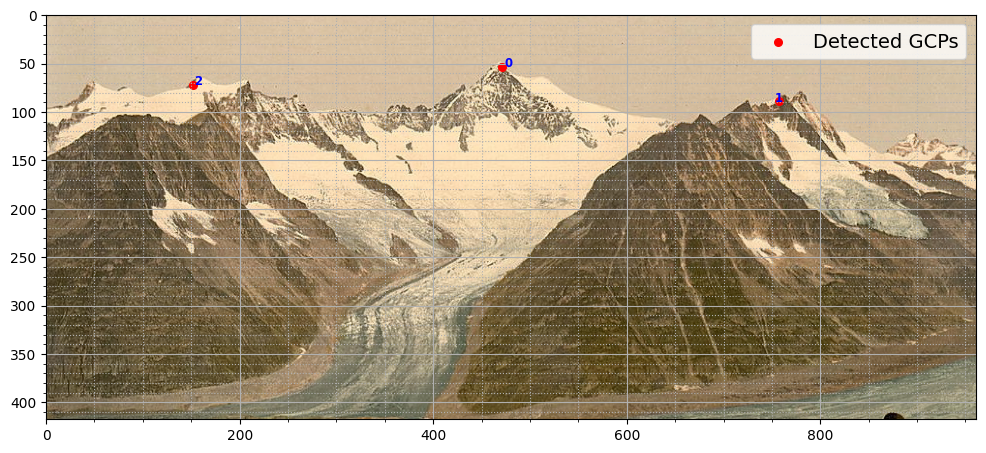

In [66]:
listSelectedImgKeyPnts = np.arange(Image_keypoints.shape[0])
listSelectedImgKeyPnts = [23 , 30, 49]

Selected_Image_keypoints = Image_keypoints[listSelectedImgKeyPnts]


fig= plt.figure(figsize=(12,15))
plt.imshow(img2[:,:,::-1])
plt.scatter(Selected_Image_keypoints[:,0], Selected_Image_keypoints[:,1],
            s=30, c='r', label='Detected GCPs')
plt.axis('scaled')

plt.xlim(0,width_img)
# plt.ylim(0,height_img)
# plt.gca().invert_yaxis()
plt.grid(which='major')
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
plt.legend(fontsize=14)

for i in range(Selected_Image_keypoints.shape[0]):
        margin = Selected_Image_keypoints[i,0]*((-1)**i)*0.005
        plt.text(Selected_Image_keypoints[i,0]+margin, Selected_Image_keypoints[i,1], str(i),
                horizontalalignment='left', size='small', color='blue', weight='semibold')
plt.show()

# DEM Keypoints

In [51]:
pathMesh = "large-size-data/Final_refined_Mesh.stl"
MTNMeshSurf = o3d.io.read_triangle_mesh(pathMesh)
MTNMeshSurf.remove_duplicated_vertices()
MTNMeshSurf.remove_duplicated_triangles()

TriangleMesh with 492247 points and 981677 triangles.

In [52]:
gray_image = cv2.imread('data/DEM_Image_Gray_No_deletion.jpg', cv2.COLOR_BGR2GRAY)
DEM_Raster_keypoint = np.loadtxt('data/DEM_Raster_keypoint.out', delimiter=',').round().astype('int64')
Geo_Keypoints = np.loadtxt('data/Geo_Keypoints_no_deletion.out', delimiter=',')

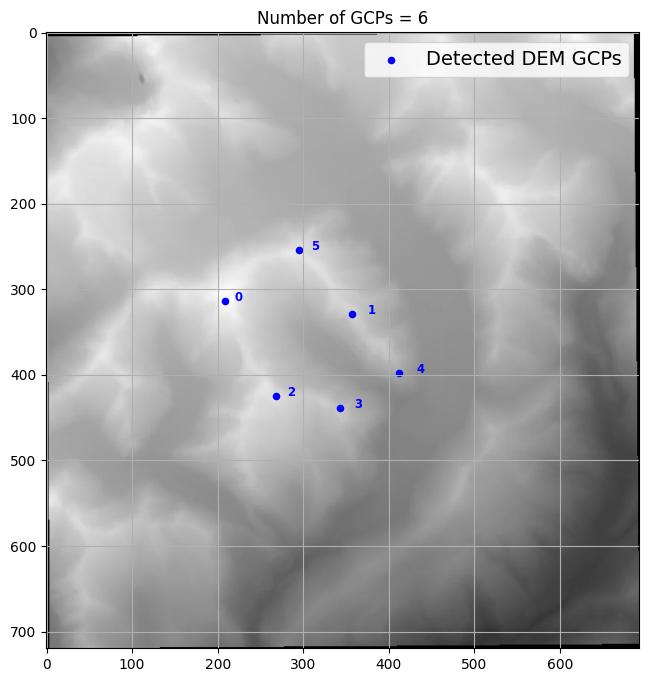

In [55]:
listSelectedImgKeyPnts = np.arange(DEM_Raster_keypoint.shape[0])
listSelectedDEMKeyPnts = [7 , 17, 20, 21 , 19, 16]

Selected_DEM_Raster_keypoint = DEM_Raster_keypoint[listSelectedDEMKeyPnts]
Selected_Geo_Keypoints = Geo_Keypoints[listSelectedDEMKeyPnts]

if len(Selected_DEM_Raster_keypoint)==0:
    print("no keypoint founded")
else:
    fig = plt.figure(figsize = (12, 8))
    plt.imshow(gray_image, cmap='gray')
    plt.scatter(Selected_DEM_Raster_keypoint[:,0],
                Selected_DEM_Raster_keypoint[:,1], c='b', s=20, label='Detected DEM GCPs')
#     plt.gca().invert_yaxis() ######################################
#     plt.gca().invert_xaxis()
    plt.title('Number of GCPs = '+ str(Selected_DEM_Raster_keypoint.shape[0]))

    for i in range(Selected_DEM_Raster_keypoint.shape[0]):
        margin = Selected_DEM_Raster_keypoint[i,0]*0.05
        plt.text(Selected_DEM_Raster_keypoint[i,0]+margin, Selected_DEM_Raster_keypoint[i,1], str(i),
                horizontalalignment='left', size='small', color='blue', weight='semibold')
    plt.legend(fontsize=14)

    plt.grid()
    plt.show()

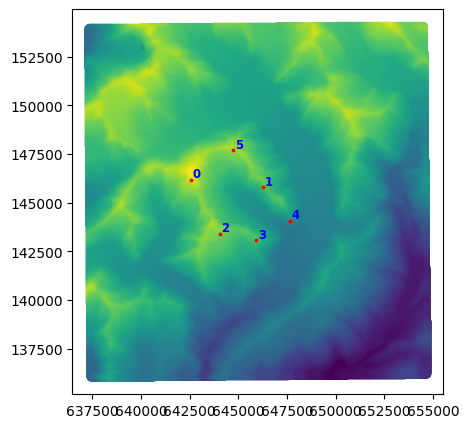

In [56]:
fig = plt.figure(figsize = (10, 5))
plt.scatter(np.asarray(MTNMeshSurf.vertices)[:,0],
            np.asarray(MTNMeshSurf.vertices)[:,1],
            c=np.asarray(MTNMeshSurf.vertices)[:,2])

plt.scatter(Selected_Geo_Keypoints[:,0],
            Selected_Geo_Keypoints[:,1], c='red', s=3)

plt.axis('scaled')

for i in range(Selected_Geo_Keypoints.shape[0]):
    margin = 100   #Selected_Geo_Keypoints[i,0]*0.05
    plt.text(Selected_Geo_Keypoints[i,0]+margin,
             Selected_Geo_Keypoints[i,1]+margin,
             str(i),
             horizontalalignment='left', size='small', color='blue', weight='semibold')
plt.show()

# Torch Projection Function

In [57]:
def TorchRotationMatrix(axis: str, angle):
  cos = torch.cos(angle)
  sin = torch.sin(angle)
  one = torch.ones_like(angle)
  zero = torch.zeros_like(angle)


  if axis == "X":
    R_flat = (one, zero, zero, zero, cos, -sin, zero, sin, cos)
  if axis == "Y":
    R_flat = (cos, zero, sin, zero, one, zero, -sin, zero, cos)
  if axis == "Z":
    R_flat = (cos, -sin, zero, sin, cos, zero, zero, zero, one)
  return torch.stack(R_flat, -1).reshape((3, 3))

In [58]:
def TorchEulerAnglesToRotationMatrixDegree(theta):

  R_x = TorchRotationMatrix("X", theta[0])
  R_y = TorchRotationMatrix("Y", theta[1])
  R_z = TorchRotationMatrix("Z", theta[2])

  return torch.matmul(R_z, torch.matmul(R_y, R_x))

In [59]:
def Projection(PointCloud,
               Cam_x, Cam_y, Cam_z,
               theta1, theta2, theta3,
               FL_x, FL_y,
               camera_center, Image_height):    # Pointcloud, Cam_xyz, theta123,

  import torch
  import numpy as np
  from math import pi

  N_p = PointCloud.shape[0]

  Cam_pos = torch.stack((Cam_x, Cam_y, Cam_z), -1)
  tvec = - Cam_pos

  THETA = torch.stack((theta1, theta2, theta3), -1)
  THETA_rad = THETA*(pi/180)
  RotMatrix = TorchEulerAnglesToRotationMatrixDegree(THETA_rad)

  focal_length = - torch.tensor((FL_x,FL_y), dtype=torch.float64)

  camera_matrix = torch.tensor([[focal_length[0], 0, camera_center[1]-0.5],
                                [0, focal_length[0], camera_center[0]-0.5],
                                [0, 0, 1]],)


  Translated = (PointCloud + tvec)
  xyz = torch.bmm(RotMatrix.repeat(N_p,1).reshape(N_p,3,3), Translated.reshape(N_p,3,1))
  xyz_prime = xyz / xyz[:,2].unsqueeze(1)
  uv = torch.bmm(camera_matrix.repeat(N_p,1).reshape(N_p,3,3), xyz_prime).reshape(N_p,3)


  Y_invert = torch.tensor([1, -1, 1], dtype=torch.float64).repeat(N_p,1)
  Y_invert_height = torch.tensor([0, Image_height, 0]).repeat(N_p,1)

  uv_final = ((uv * Y_invert) + Y_invert_height)[:,0:2]
  return uv_final

In [60]:
def LossFunction(ProjedPoints, detectedCorners):
  N_p = ProjedPoints.shape[0]
  N_d = detectedCorners.shape[0]

  Tdet_corners_expanded = detectedCorners.reshape(N_d, 1, 2).repeat_interleave(N_p,dim=1)
  Loss = ((Tdet_corners_expanded - ProjedPoints)**2).sum(dim=2).sqrt().min(dim=1)[0].sum()
  return Loss

# PyTorch Optimization

In [63]:
def ProjectionShow(T_Detected_Corners, T_Projected_Points, imageToshow):

    Detected_Corners = T_Detected_Corners.detach().numpy()
    Projected_Points = T_Projected_Points.detach().numpy()


    fig= plt.figure(figsize=(12,15))
    plt.imshow(imageToshow[:,:,::-1])
    plt.scatter(Detected_Corners[:,0], Detected_Corners[:,1], s=30, c='r', label='Detected GCPs')
    plt.scatter(Projected_Points[:,0], Projected_Points[:,1], s=50,  facecolors='none', edgecolors='b',
                alpha=1, label='Projected DEM GCPs') #c='b',
    plt.axis('scaled')

    # plt.xlim(-1.5*width_img,width_img*1.5)
    # plt.ylim(-1.5*height_img,height_img*1.5)

    plt.xlim(0, width_img)
    plt.ylim(height_img, 0)
    # plt.gca().invert_yaxis()

    plt.grid(which='major')
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':')
    plt.legend(fontsize=14, framealpha=0.5)
    plt.show()
    return

In [64]:
def TorchEulerAnglesToRotationMatrixDegree(THETA_rad):
  R_x = TorchRotationMatrix("X", THETA_rad[0])
  R_y = TorchRotationMatrix("Y", THETA_rad[1])
  R_z = TorchRotationMatrix("Z", THETA_rad[2])
  return torch.matmul(R_z, torch.matmul(R_y,R_x))

def TorchRotationMatrix(axis: str, angle):
  cos = torch.cos(angle)
  sin = torch.sin(angle)
  one = torch.ones_like(angle)
  zero = torch.zeros_like(angle)

  if axis == "X":
    R_flat = (one, zero, zero, zero, cos, -sin, zero, sin, cos)
  if axis == "Y":
    R_flat = (cos, zero, sin, zero, one, zero, -sin, zero, cos)
  if axis == "Z":
    R_flat = (cos, -sin, zero, sin, cos, zero, zero, zero, one)
  return torch.stack(R_flat, -1).reshape((3, 3))

In [65]:
class ProjectModel(torch.nn.Module):
  def __init__(self, cx, cy, cz, th1, th2, th3, VA):

    super().__init__()


    self.Cam_x = torch.nn.Parameter(torch.tensor(cx, dtype=torch.float64, requires_grad=True))
    self.Cam_y = torch.nn.Parameter(torch.tensor(cy, dtype=torch.float64, requires_grad=True))
    self.Cam_z = torch.nn.Parameter(torch.tensor(cz, dtype=torch.float64, requires_grad=True))
    self.theta1 = torch.nn.Parameter(torch.tensor(th1, dtype=torch.float64, requires_grad=True))
    self.theta2 = torch.nn.Parameter(torch.tensor(th2, dtype=torch.float64, requires_grad=True))
    self.theta3 = torch.nn.Parameter(torch.tensor(th3, dtype=torch.float64, requires_grad=True))
    self.ViewAngle= torch.nn.Parameter(torch.tensor(VA, dtype=torch.float64, requires_grad=True))


    self.params = torch.nn.ParameterList([self.Cam_x, self.Cam_y, self.Cam_z, self.theta1, self.theta2])
    self.changeway= False
###########################################################################################

  def forward(self, PntCld, dtcCor, lambda_1, lambda_2, lambda_3):
    self.dev = self.Cam_z.device
    self.lambda_1 = torch.tensor(lambda_1, dtype=torch.float64, requires_grad=False)
    self.lambda_2 = torch.tensor(lambda_2, dtype=torch.float64, requires_grad=False)
    self.lambda_3 = torch.tensor(lambda_3, dtype=torch.float64, requires_grad=False)

    self.PointCloud = PntCld.to(self.dev)
    self.detectedCorners = dtcCor.to(self.dev)
    self.N_d = self.detectedCorners.shape[0]
    self.N_p = self.PointCloud.shape[0]


    self.img_size=(width_img, height_img)

    self.FL_x=(self.img_size[1])/(2*torch.tan((self.ViewAngle/2)*(pi/180.)))
    self.FL_y=(self.img_size[0])/(2*torch.tan((self.ViewAngle/2)*(pi/180.)))
    self.camera_center=(self.img_size[1]/2, self.img_size[0]/2)
    self.Image_height=self.img_size[1]

    self.THETA = torch.stack((self.theta1, self.theta2, self.theta3), -1)
    self.THETA_rad = self.THETA*(pi/180)


    self.Cam_pos = torch.stack((self.Cam_x, self.Cam_y, self.Cam_z), -1)
    self.tvec = - self.Cam_pos


    self.RotMatrix = TorchEulerAnglesToRotationMatrixDegree(self.THETA_rad).to(self.dev)

    self.focal_length = - torch.stack((self.FL_x, self.FL_y), -1)

    self.camera_matrix = torch.stack(
         (self.focal_length[0], torch.tensor(0), torch.tensor(self.camera_center[1])-0.5,
          torch.tensor(0), self.focal_length[0], torch.tensor(self.camera_center[0])-0.5,
          torch.tensor(0), torch.tensor(0), torch.tensor(1)) ).reshape((3,3))



    self.Translated = (self.PointCloud + self.tvec)
    self.xyz = torch.bmm(self.RotMatrix.repeat(self.N_p,1).reshape(self.N_p,3,3), self.Translated.reshape(self.N_p,3,1))
    self.xyz_prime = self.xyz / self.xyz[:,2].unsqueeze(1)
    self.uv = torch.bmm(self.camera_matrix.repeat(self.N_p,1).reshape(self.N_p,3,3), self.xyz_prime).reshape(self.N_p,3)


    self.Y_invert = torch.tensor([1, -1, 1], dtype=torch.float64, device=self.dev).repeat(self.N_p,1)
    self.Y_invert_height = torch.tensor([0, self.Image_height, 0], device=self.dev).repeat(self.N_p,1)


    self.uv_final = ((self.uv * self.Y_invert) + self.Y_invert_height)[:,0:2]




    self.Tdet_corners_expanded = self.detectedCorners.reshape(self.N_d, 1, 2).repeat_interleave(self.N_p,dim=1)
    self.Loss = ((self.Tdet_corners_expanded - self.uv_final)**2).sum(dim=2).min(dim=1)[0].sum()



    self.MaxDist_detCorners = (self.detectedCorners.reshape(self.N_d, 1, 2).repeat_interleave(self.N_d, dim=1)
         - self.detectedCorners).pow(2).sum(dim=2, keepdim=True).max()
    self.MaxDist_ProjPoints =(self.uv_final.reshape(self.N_p, 1, 2).repeat_interleave(self.N_p, dim=1)
         - self.uv_final).pow(2).sum(dim=2, keepdim=True).max()

    self.Loss2 = ((self.MaxDist_ProjPoints - self.MaxDist_detCorners).pow(2).sqrt())

    self.Loss2p = (((Pmodel.uv_final - Pmodel.uv_final.mean(dim=0, keepdim=True)).pow(2).mean(dim=0)) -
                   ((Pmodel.detectedCorners - Pmodel.detectedCorners.mean(dim=0, keepdim=True)).pow(2).mean(dim=0))).pow(2).sum()


    self.Loss3 = (self.uv_final.mean(dim=0, keepdim=True) - self.detectedCorners.mean(dim=0, keepdim=True)).pow(2).sum()




    # if (self.gradval<5) and (self.Num_distinct_pnts_in_loss<=3) and self.changeway==False:
    #   self.lambda_2 = torch.tensor(0.1, dtype=torch.float64)
    #   self.changeway=True
    # elif (self.gradval<1) and (self.Num_distinct_pnts_in_loss>10) and self.changeway==True:
    #   self.lambda_2 = torch.tensor(0.0, dtype=torch.float64)

    # if (self.gradval2<2) and (self.Num_distinct_pnts_in_loss>10) and self.changeway==False:
    #   self.lambda_2 = torch.tensor(0.0, dtype=torch.float64)

    # if (self.gradval < 10) and (self.gradval2 < 1):
    #   # self.lambda_1 = self.gradval*0.1
    #   self.lambda_2 = self.gradval2*10

    # if (self.Num_distinct_pnts_in_loss >= int(self.N_d*0.6)):
    #   self.lambda_2 = torch.tensor(0.0, dtype=torch.float64)
    #   self.lambda_3 = torch.tensor(0.0, dtype=torch.float64)


    self.Loss1C = self.lambda_1*self.Loss
    self.Loss2C = self.lambda_2*self.Loss2p
    self.Loss3C = self.lambda_3*self.Loss3


    # self.Loss1C = (self.lambda_1 -self.lambda_2 - self.lambda_3)*self.Loss
    # self.Loss2C = self.lambda_2*self.Loss2p
    # self.Loss3C = self.lambda_3*self.Loss3


    self.Loss_total = self.Loss1C + self.Loss2C + self.Loss3C
    #------------------------------------------------------------------------------------------------------
    with torch.no_grad():
      self.Num_distinct_pnts_in_loss = torch.tensor(torch.unique((((self.Tdet_corners_expanded.detach() -
                                                  self.uv_final.detach())**2).sum(dim=2, keepdim=True)).sqrt().argmin(0)).size()[0],
                                                dtype=torch.float64)
      self.gradval = torch.autograd.grad(outputs=self.Loss1C, inputs=[p for p in self.params], retain_graph=True)
      self.gradval = torch.FloatTensor(list(self.gradval)).sum().detach()

      # self.gradval2 = torch.autograd.grad(outputs=self.Loss2C, inputs=[q for q in self.params], retain_graph=True)
      # self.gradval2 = torch.FloatTensor(list(self.gradval2)).sum().detach()

      self.gradval3 = torch.autograd.grad(outputs=self.Loss3C, inputs=[q for q in self.params], retain_graph=True)
      self.gradval3 = torch.FloatTensor(list(self.gradval3)).sum().detach()
    #------------------------------------------------------------------------------------------------------






    return self.Loss_total #+ self.Loss22


  def solution(self,):
    return self.Cam_y.item(), self.Cam_z.item()

###########################################################################################

In [29]:
Tpoints = torch.from_numpy(Selected_Geo_Keypoints)
Tdet_corners= torch.from_numpy(Selected_Image_keypoints)

Pmodel = ProjectModel(659300, 143700, 3200, 260, -50, -1, 30)
# Pmodel = ProjectModel(649323.4946735367, 142744.31005438883, 2805.999091620659, 269.69094211, -62.23, -0.369, 26.45)

LRAdap = .1

optimizer = torch.optim.Adadelta(Pmodel.parameters(), lr=LRAdap, rho=0.9, eps=1e-06)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000], gamma=0.5)

In [35]:
%%time
import time
# torch.cuda.synchronize()
t0 = time.time()


SolVals_old = torch.tensor([q for q in Pmodel.params])
gradval_old = 0
Loss1_old = 0.1
interval_check = 300
converg_err = 0.001 #0.01
loss_history = []
percent = 1
percent_interval_check = 1

lambda1 = 1.0
lambda2 = 0
lambda3 = 0


t=0
while True:

    loss_P = Pmodel(Tpoints, Tdet_corners, lambda1, lambda2, lambda3)
    # loss_P = Pmodel(Tpoints, Tdet_corners, lambda1, 0, 0)
    loss_history.append(loss_P.item())

    # if Pmodel.Loss3 < 1: lambda3 = 0

    if t>3:
      percent = -(100*(loss_history[-1]-loss_history[-3])/
                           loss_history[-3])

    if t % interval_check == 0:
      if (t>=interval_check):
        percent_interval_check = -(100*(loss_history[-1]-loss_history[-(interval_check)])/
                           loss_history[-interval_check])

      print('t:{:2d}, {:6.2f}, %: {:6.2f},  Loss:{:.2f}, {:.2f}, {:.2f} \t N_Points:{:2d} \t GradVals:{:.2f}, {:.2f} \t Ans:{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(
                                                            np.int64(t),
                                                            np.round(optimizer.param_groups[0]['lr'],2),
                                                            np.round(percent_interval_check, 3),
                                                                np.round(Pmodel.Loss1C.item(),2),
                                                                np.round(Pmodel.Loss2C.item(),2),
                                                                np.round(Pmodel.Loss3C.item(),2),
                                                                np.int64(Pmodel.Num_distinct_pnts_in_loss.item()),
                                                                np.round(Pmodel.gradval.item(),2),
                                                                np.round(Pmodel.gradval3.item(),2),
                                                                [np.round(p.item(),2) for p in Pmodel.params][0],
                                                                [np.round(p.item(),2) for p in Pmodel.params][1],
                                                                [np.round(p.item(),2) for p in Pmodel.params][2],
                                                                [np.round(p.item(),2) for p in Pmodel.params][3],
                                                                [np.round(p.item(),2) for p in Pmodel.params][4]))


    if ((abs(percent) < converg_err) & (loss_P.item()<100)) or (loss_P.item()<5):
      print('converged'+str(abs(percent)))
      break

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss_P.backward()
    optimizer.step()
    t+=1
    # scheduler.step()

loss_history = np.array(loss_history)
# torch.cuda.synchronize()
t1 = time.time()
RunTime = t1-t0
print("Running Time", RunTime)

t: 0,   0.10, %:   1.00,  Loss:74.33, 0.00, 0.00 	 N_Points: 3 	 GradVals:75.38, 0.00 	 Ans:649323.4900, 142744.3100, 2806.0000, 269.6900, -62.2300
t:300,   0.10, %:  39.09,  Loss:45.21, 0.00, 0.00 	 N_Points: 3 	 GradVals:-7.48, 0.00 	 Ans:649323.6600, 142744.2200, 2806.1600, 269.8100, -62.3100
t:600,   0.10, %:  22.46,  Loss:35.01, 0.00, 0.00 	 N_Points: 3 	 GradVals:-0.40, 0.00 	 Ans:649323.8300, 142744.1800, 2806.4100, 269.8900, -62.3400
t:900,   0.10, %:   4.10,  Loss:33.56, 0.00, 0.00 	 N_Points: 3 	 GradVals:1.85, 0.00 	 Ans:649323.9700, 142744.2800, 2806.6600, 269.8800, -62.3500
t:1200,   0.10, %:   0.93,  Loss:33.25, 0.00, 0.00 	 N_Points: 3 	 GradVals:3.41, 0.00 	 Ans:649324.1900, 142744.3400, 2806.9300, 269.8700, -62.3600
t:1500,   0.10, %:   0.81,  Loss:32.98, 0.00, 0.00 	 N_Points: 3 	 GradVals:4.58, 0.00 	 Ans:649324.4500, 142744.3900, 2807.2300, 269.8800, -62.3600
t:1800,   0.10, %:   0.91,  Loss:32.68, 0.00, 0.00 	 N_Points: 3 	 GradVals:5.47, 0.00 	 Ans:649324.7400, 14

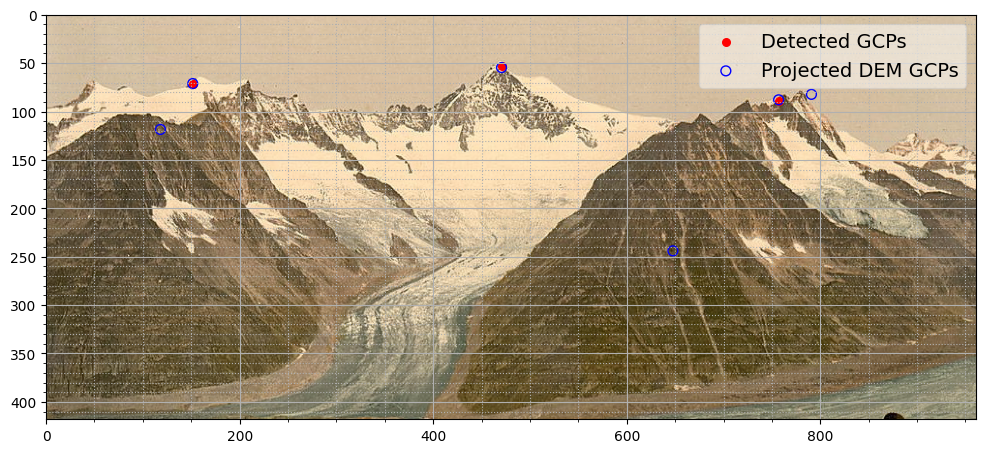

In [36]:
ProjPnts = Projection(PointCloud=Tpoints,
                      Cam_x=Pmodel.Cam_x, Cam_y=Pmodel.Cam_y, Cam_z=Pmodel.Cam_z,
                      theta1=Pmodel.theta1, theta2=Pmodel.theta2, theta3=Pmodel.theta3,
                      FL_x=Pmodel.FL_x, FL_y=Pmodel.FL_y,
                      camera_center=Pmodel.camera_center, Image_height=Pmodel.Image_height)

ProjectionShow(Tdet_corners, ProjPnts, img2)

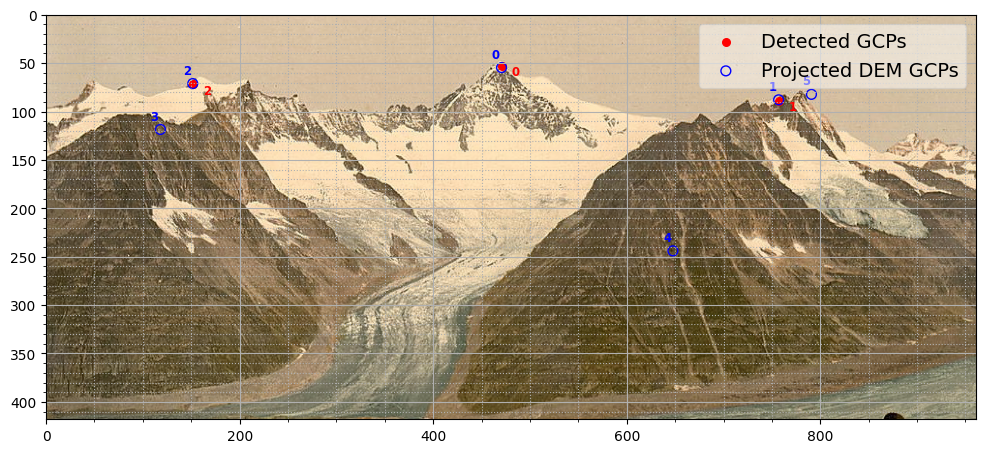

In [37]:
DetCorners = Tdet_corners.detach().numpy()
ProjPoints = ProjPnts.detach().numpy()


fig= plt.figure(figsize=(12,15))
plt.imshow(img2[:,:,::-1])
plt.scatter(DetCorners[:,0], DetCorners[:,1], s=30, c='r', label='Detected GCPs')
plt.scatter(ProjPoints[:,0], ProjPoints[:,1], s=50,  facecolors='none', edgecolors='b',
            alpha=1, label='Projected DEM GCPs') #c='b',
plt.axis('scaled')

# plt.xlim(-1.5*width_img,width_img*1.5)
# plt.ylim(-1.5*height_img,height_img*1.5)

plt.xlim(0, width_img)
plt.ylim(height_img, 0)
# plt.gca().invert_yaxis()

for i in range(DetCorners.shape[0]):
    margin = 10   #Selected_Geo_Keypoints[i,0]*0.05
    plt.text(DetCorners[i,0]+margin,
             DetCorners[i,1]+margin,
             str(i),
             horizontalalignment='left', size='small', color='red', weight='semibold')

for i in range(ProjPoints.shape[0]):
    margin = -10   #Selected_Geo_Keypoints[i,0]*0.05
    plt.text(ProjPoints[i,0]+margin,
             ProjPoints[i,1]+margin,
             str(i),
             horizontalalignment='left', size='small', color='blue', weight='semibold')

plt.grid(which='major')
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
plt.legend(fontsize=14, framealpha=0.5)
plt.show()

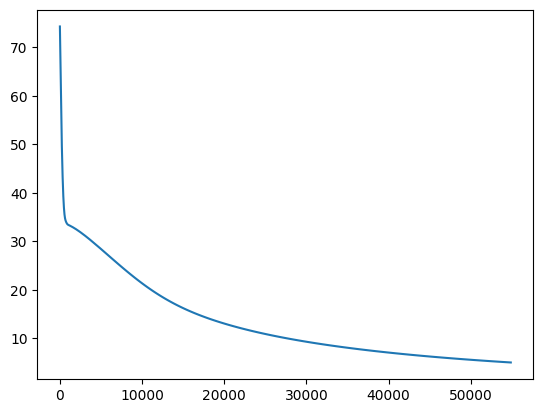

In [41]:
plt.plot(loss_history)

In [ ]:
def Rotation_Matrix(pitch_x, heading_y, roll_z):

    from numpy.linalg import multi_dot

    theta = np.array([pitch_x, heading_y, roll_z])*(pi/180)
    R_pitch_x = np.array([[1,         0,                  0                ],
                          [0,         np.cos(theta[0]),  -np.sin(theta[0]) ],
                          [0,         np.sin(theta[0]),   np.cos(theta[0]) ] ])

    R_heading_y = np.array([[np.cos(theta[1]),    0,      np.sin(theta[1])  ],
                            [0,                     1,      0                   ],
                            [-np.sin(theta[1]),   0,      np.cos(theta[1])  ]
                            ])

    R_roll_z = np.array([[np.cos(theta[2]),    -np.sin(theta[2]),    0],
                        [np.sin(theta[2]),    np.cos(theta[2]),     0],
                        [0,                     0,                      1]
                        ])

    RotationMatrix = multi_dot([ R_roll_z, R_heading_y,  R_pitch_x])

    return RotationMatrix

def OpenGLandCV_to_Open3D_Angles_deg(OpenGLandCV_angles):
    Coordinate_Rotate = Rotation_Matrix(180,0,0).round(1)
    OP3D_angles = np.matmul(Coordinate_Rotate, OpenGLandCV_angles)-np.array([180,0,0])
    return OP3D_angles

def Open3D_to_OpenGLandCV_Angles_deg(OP3D_angles):
    Coordinate_Rotate = Rotation_Matrix(180,0,0).round(1)
    OpenGLCV_angles = np.matmul(Coordinate_Rotate, OP3D_angles)+np.array([180,0,0])
    return OpenGLCV_angles

In [ ]:
OCV_Angles = np.array([Pmodel.theta1.item(), Pmodel.theta2.item(), Pmodel.theta3.item()])
OCV_Angles

array([269.69094211, -62.2301418 ,  -0.36972229])

In [ ]:
O3D_Angles = OpenGLandCV_to_Open3D_Angles_deg(OCV_Angles)
O3D_Angles

array([92.28783633, 62.85395886,  1.77627365])